# Fields

We demonstrate the gridding of fields with `cygrid`, using infrared data from Planck and WISE. While these images are only two-dimensional, we note that `cygrid` was designed for spectroscopic HI data, so the handling of the spectral axis is well-supported.

We start by adjusting the notebook settings.

In [139]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We attempt to limit our dependencies as much as possible, but [`astropy`](https://astropy.readthedocs.org/en/stable/) and [`healpy`](http://healpy.readthedocs.org) needs to be available on your machine if you want to re-run the calculations. We can highly recommend [`anaconda`](https://www.continuum.io/downloads) as a scientific `python` platform.

In [140]:
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams

import healpy as hp
from astropy.io import fits
from astropy.coordinates import SkyCoord
# We'll be loading some data from skyview, hence the longer timeout
from astropy.utils.data import conf
conf.remote_timeout = 60.
from wcsaxes import WCS

import cygrid

We change the `matplotlib` settings to improve and standardise our plots.

In [141]:
params = {
    'backend': 'pdf',
    'text.latex.preamble': ['\usepackage{gensymb}'],
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'font.size': 8,
    'legend.fontsize': 8,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'font.family': 'serif',
    'figure.dpi': 150
}

rcParams.update(params)

Let's furthermore define some plotting `kwargs` for the images.

In [142]:
imkw = dict(
    origin='lower',
    cmap='binary_r',
    interpolation='None')

## 1) Gridding one fits-file onto another

For our first demonstration, we illustrate how to grid from a large fits-file onto another one with a different extent and coordinate system.
First, we need to obtain our input image. We use `skyview` to get an image of WISE 22 micron data.

In [143]:
input_data, input_header = fits.getdata(
    'http://skyview.gsfc.nasa.gov/current/cgi/runquery.pl?Survey=WISE+22&position=200.,15.&pixels=1500&Return=FITS',
    header=True)

This image is in equatorial coordinates and approximately $34'\times34'$ large. The angular resolution is rougly 12 arcseconds.

In [144]:
print 'Projection:', input_header['CTYPE1']
print 'Fieldsize:', np.abs(input_header['NAXIS1'] * input_header['CDELT1'])*60, 'arcmin'

Projection: RA---TAN
Fieldsize: 34.371 arcmin


Here's an image of what this field looks like. `wcsaxes` is a simple tool to combine the `matplotlib` with information from the world-coordinate system (WCS).

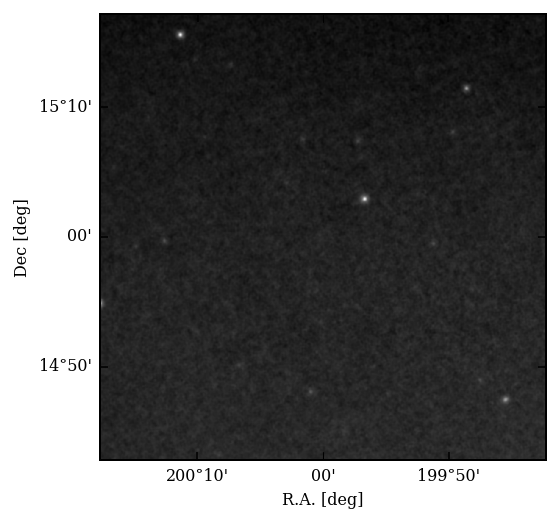

In [145]:
input_wcs = WCS(input_header)
fig = pl.figure()
ax = fig.add_subplot(111, projection=input_wcs)
lon, lat = ax.coords
ax.imshow(input_data, **imkw)
lon.set_axislabel('R.A. [deg]')
lat.set_axislabel('Dec [deg]')

We download another far-infrared image onto which we will grid the WISE 22 micron data. For simplicity, we choose the WISE 12 micron data.

In [146]:
target_data, target_header = fits.getdata(
    'http://skyview.gsfc.nasa.gov/current/cgi/runquery.pl?Survey=WISE+12&position=333.,76.&coordinates=Galactic&pixels=500&Return=FITS', header=True)

We use a smaller field with a different coordinate system.

In [147]:
print 'Projection:', target_header['CTYPE1']
print 'Fieldsize:', np.abs(target_header['NAXIS1'] * target_header['CDELT1'])*60, 'arcmin'

Projection: GLON-TAN
Fieldsize: 11.457 arcmin


And here is how our target field looks like:

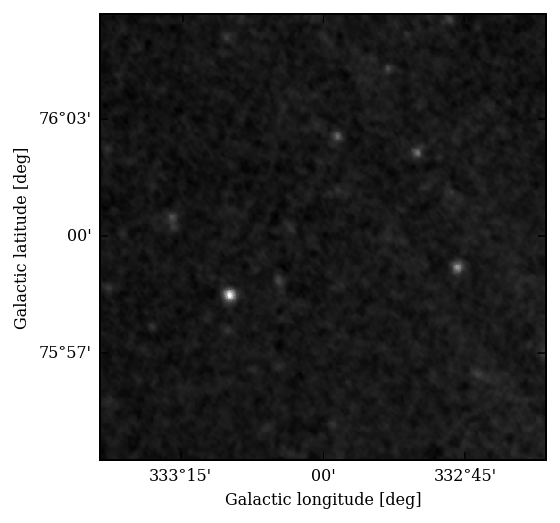

In [148]:
target_wcs = WCS(target_header)
fig = pl.figure()
ax = fig.add_subplot(111, projection=target_wcs)
lon, lat = ax.coords
ax.imshow(target_data, **imkw)
lon.set_axislabel('Galactic longitude [deg]')
lat.set_axislabel('Galactic latitude [deg]')

We start the gridding by initating the gridder with the `target_header`. Prior to this, we need to add a third axis to this header because `cygrid` was designed for three-dimensional data.

We might change this in the future, but this work-around is required until then.

In [149]:
target_header_3d = target_header.copy()
target_header_3d['NAXIS'] = 3
target_header_3d['NAXIS3'] = 1

gridder = cygrid.WcsGrid(target_header_3d)

To grid one image onto another, we need the coordinates for each pixel in the input image. To obtain these, we start by getting pixel coordinates with `np.meshgrid`.

In [150]:
input_lon_pix, input_lat_pix = np.meshgrid(np.arange(input_header['NAXIS1']), np.arange(input_header['NAXIS2']))

Next, we convert these from pixel- to world-coordinates, using the `wcs` features from `astropy`.

In [151]:
input_lon_world, input_lat_world = input_wcs.all_pix2world(input_lon_pix, input_lat_pix, 0)

Lastly, we convert the coordinates from equatorial to galactic. This is really simple and straightforward as well.

In [152]:
coords_eq = SkyCoord(input_lon_world, input_lat_world, frame='icrs', unit='deg')
coords_gal = coords_eq.galactic

Aside from the data that we use for the gridding, we need the `weights` as well. We will simply use uniform weighting here.

In [153]:
weights = np.ones_like(input_data, dtype=np.float32)

The gridding kernel is of key importance for the entire gridding process. `cygrid` allows you to specify the shape of the kernel (e.g. elliptical Gaussian or tapered sinc) and its size.

In our example, we use a symmetrical Gaussian (i.e. the major and minor axis of the kernel are identical). In that case, we need to furthermore specify `1/kernelsigma^2`, the `kernelradius` up to which the kernel will be computed, and the maximum acceptable healpix resolution for which we recommend `kernelsigma/2`.

In [154]:
kernelfwhm = 6./3600.
kernelsigma = kernelfwhm / 2.355
kernelradius = 3. * kernelsigma

gridder.set_kernel(
    'gauss1d',
    (1. / kernelsigma ** 2,),
    kernelradius,
    kernelsigma / 2.
    )

After the kernel has been set, we perform the actual gridding by calling `grid()` with the flattened coordinates, the data, and the weights.

In [155]:
gridder.grid(
    coords_gal.l.value.flatten(),
    coords_gal.b.value.flatten(),
    input_data.reshape(-1, 1).astype(np.float32),
    weights.reshape(-1, 1))

We need to add a degenerate axis to the latter two because of the design for spectroscopic data:

In [156]:
input_data.reshape(-1, 1).shape

(2250000, 1)

To get the gridded data, we simply call `get_datacube()`.

In [157]:
datacube = gridder.get_datacube()

/Users/dlenz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Here's how the gridded field looks like, superposed with the data onto which we gridded our input data.

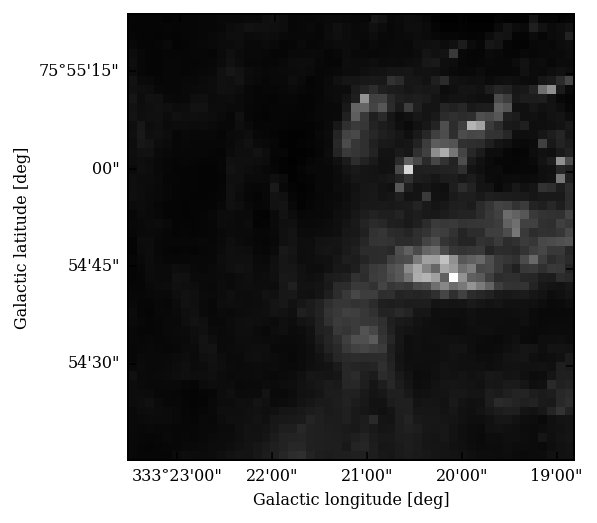

In [138]:
fig = pl.figure()
ax = fig.add_subplot(111, projection=target_wcs)
lon, lat = ax.coords
ax.imshow(datacube[0], **imkw)
# ax.contour(target_data, colors='red', levels=np.arange(3.e-2, 1.e1, 3))
lon.set_axislabel('Galactic longitude [deg]')
lat.set_axislabel('Galactic latitude [deg]')

## 2) Gridding from full-sky data onto a self-made fits-header

In the second part of this notebook, we demonstrate how to grid from a full-sky data set in healpix onto a user-defined header.

We start by loading the Planck 545 GHz intensity map from `skyview`. The map is roughtly 600 MB large, so it might take a few minutes.

In [120]:
fullsky_data, fullsky_header = fits.getdata(
    'http://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/HFI_SkyMap_545_2048_R2.02_full.fits',
    header=True)

We use the intensity and convert the healpix ordering from nested to ring.

In [121]:
fullsky_intensity = hp.reorder(fullsky_data['I_STOKES'], n2r=True).astype(np.float32)

The properties of the map are given by the ordering and the nside of the map. For more details, check the paper by [Gorski et al. (2005)](http://adsabs.harvard.edu/abs/2005ApJ...622..759G).

In [122]:
NPIX = int(fullsky_intensity.size)
NSIDE = hp.npix2nside(NPIX)

Here's a beautiful picture of the thermal dust emission in the Milky Way.

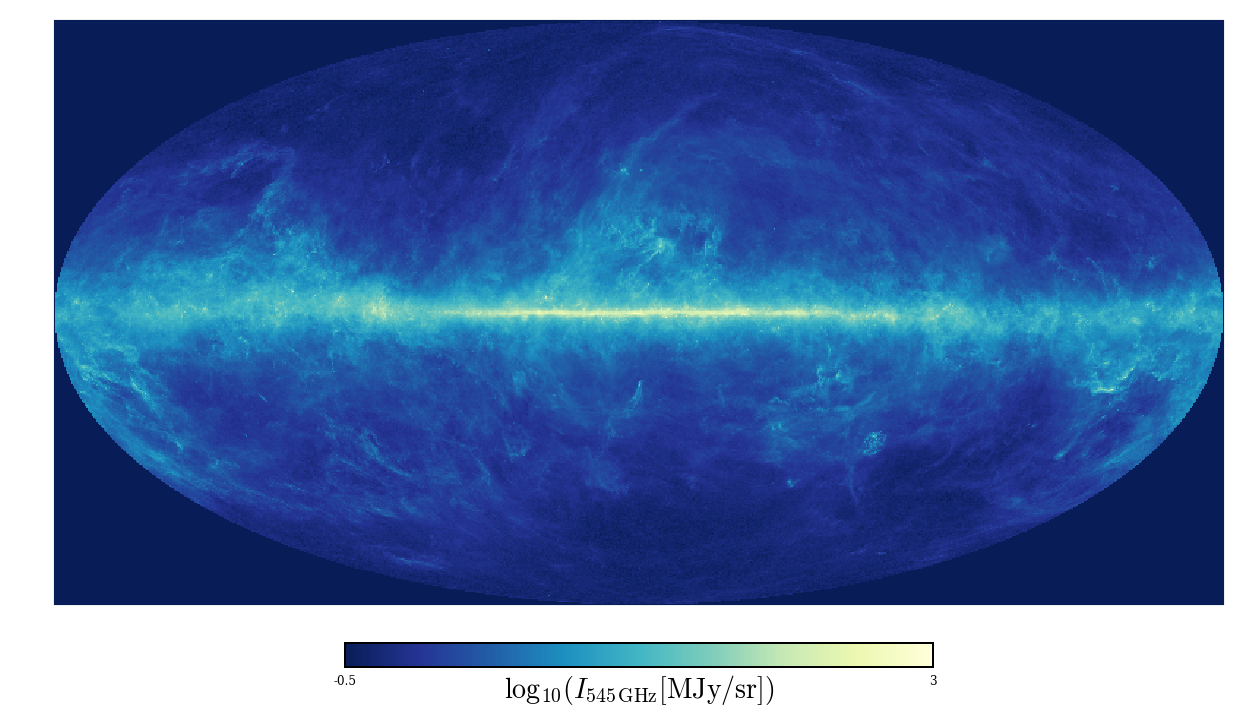

In [123]:
hp.mollview(
    np.log10(fullsky_intensity),
    cmap='YlGnBu_r',
    title='',
    unit=r'$\mathrm{log_{10}}(I_{\rm 545\,GHz} [\rm MJy/sr])$',
    min=-0.5,
    max=3.)

We manually create the `header` onto which we will grid the data. You need to make sure that all the celestial information are available and that the header is three-dimensional.

In [124]:
header = fits.Header()

pixsize = 10./60.

header['SIMPLE'] = 'T'
header['BITPIX'] = -32
header['NAXIS1'] = 50
header['NAXIS2'] = 50
header['NAXIS3'] = 1
header['NAXIS'] = 3
header['CDELT1'] = -pixsize
header['CDELT2'] = pixsize
header['CDELT3'] = 1.
header['CRPIX1'] = 0
header['CRPIX2'] = 0
header['CRPIX3'] = 0
header['CRVAL1'] = 180.
header['CRVAL2'] = 10.
header['CRVAL3'] = 0.
header['CTYPE1'] = 'GLON'
header['CTYPE2'] = 'GLAT'
header['CTYPE3'] = 'VRAD'
header['BUNIT'] = 'MJY.SR**-1'

wcs = WCS(header)

In [125]:
gridder = cygrid.WcsGrid(header)

Similar to the previous example, we need to define the `weights` and the coordinates for the input image. For healpix data, this is really straightforward and can easily be done with the `healpy` package.

In [126]:
weights = np.ones_like(fullsky_intensity, dtype=np.float32)

theta, phi = hp.pix2ang(NSIDE, np.arange(NPIX))
lons = np.rad2deg(phi).astype(np.float64)
lats = (np.rad2deg(theta) - 90.).astype(np.float64)

We select a gridding kernel of 3 arcmin.

In [127]:
kernelfwhm = 3./60.
kernelsigma = kernelfwhm / 2.355
kernelradius = 3. * kernelsigma

gridder.set_kernel(
    'gauss1d',
    (1. / kernelsigma ** 2,),
    kernelradius,
    kernelsigma / 2.
    )

Once again, we need to add a degenerate axis to the input data and weights.

In [128]:
gridder.grid(lons, lats, fullsky_intensity[:, None], weights[:, None])

In [129]:
datacube = gridder.get_datacube()

And here is how our gridded field looks like.

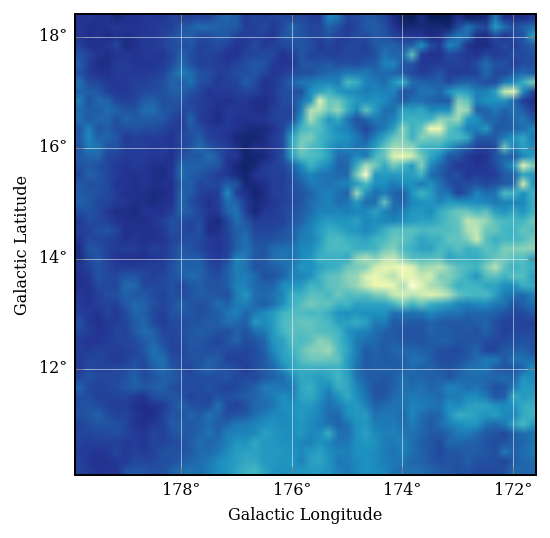

In [130]:
fig = pl.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=wcs.celestial)
lon, lat = ax.coords
lon.set_axislabel('Galactic Longitude')
lat.set_axislabel('Galactic Latitude')
ax.imshow(np.log10(datacube[0]), origin='lower', cmap='YlGnBu_r')
ax.coords.grid(color='white', alpha=0.5, linestyle='solid')